In [2]:
import mysql.connector
import pandas as pd
import numpy as np  
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import json
from scipy import stats
import os
import _pickle as cPickle

os.chdir("C:/Users/Nicholas Bonaker/PycharmProjects/NomonWeb/")
    
def calculate_quantiles(plot_df, metric):
    lower_quantiles = plot_df[["Keyboard", "Session Number",metric]].groupby(by=["Keyboard", "Session Number"]).quantile(q=0.25)
    lower_quantiles = lower_quantiles.reset_index()
    nomon_lower_quantiles = lower_quantiles[lower_quantiles.Keyboard == "Nomon"][metric].values
    rowcol_lower_quantiles = lower_quantiles[lower_quantiles.Keyboard == "RCS"][metric].values
    
    upper_quantiles = plot_df[["Keyboard", "Session Number",metric]].groupby(by=["Keyboard", "Session Number"]).quantile(q=0.75)
    upper_quantiles = upper_quantiles.reset_index()
    nomon_upper_quantiles = upper_quantiles[upper_quantiles.Keyboard == "Nomon"][metric].values
    rowcol_upper_quantiles = upper_quantiles[upper_quantiles.Keyboard == "RCS"][metric].values
    
    return {"lower": {"nomon": nomon_lower_quantiles, "rowcol": rowcol_lower_quantiles},
            "upper": {"nomon": nomon_upper_quantiles, "rowcol": rowcol_upper_quantiles}}      
    
    
def r(x, y):
    return x != y


def calc_MSD(a, b):
    
    if a[-1] == "_" or a[-1] == " ":
        a = a[:-1]
    if b[-1] == "_" or b[-1] == " ":
        b = b[:-1]

    a = np.array(list(a))
    b = np.array(list(b))

    D = np.zeros((a.size, b.size))

    for i in range(a.size):
        D[i, 0] = i

    for j in range(b.size):
        D[0, j] = j

    for i in range(a.size):
        for j in range(b.size):
            D[i, j] = min(D[i-1, j]+1, D[i, j-1]+1, D[i-1, j-1] + r(a[i], b[j]))
    return D[-1, -1], D[-1, -1] / b.size

time_rotate_li = [4]
for i in range(21):
    time_rotate_li += [4*np.exp((-i)/10)]
    
scan_delay_li = [2]
for i in range(21):
    scan_delay_li += [2*np.exp((-i)/14)]

extra_delay_li = [2]
for k in range(11):
    extra_delay_li += [0.2*(10-k)]


mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="MIuserDB"
)
mycursor = mydb.cursor()


In [32]:
with open("phrases/phrases_oov.json", 'rb') as fp:
    oov_phrases = json.load(fp)

entry_df = pd.DataFrame(columns=["id", "Session Number", "Keyboard", "phrase_num", "phase", "Total Time", "typed_len", "num_click", "Click Time STDev (s)", "num_sel", 
                                 "Characters/Selection","num_corr", "start", "end", "Final Error Rate", "Time Rotate", 
                                 "Scan Delay", "Extra Delay", "is_oov", "Phrase Target", "Final Typed"])

user=84
software_names = {"nomon": "Nomon", "rowcol": "RCS"}

# Claire Picture Selection
if user == 85:
    data_tables = [
    ["nomon_session_1_user_85", "nomon", "picture"],
    ["nomon_session_2_user_85", "nomon", "picture"],
    ["nomon_session_3_user_85", "nomon", "picture"],
    ["nomon_session_4_user_85", "nomon", "picture"],
    ["nomon_session_5_user_85", "nomon", "picture"],
    ["nomon_session_6_user_85", "nomon", "picture"],
    ["nomon_session_7_user_85", "nomon", "picture"],
    ["nomon_session_8_user_85", "nomon", "picture"],
    ["nomon_session_9_user_85", "nomon", "picture"],
    
    ["nomon_session_10_user_85", "nomon", "picture"],
    ["nomon_session_11_user_85", "nomon", "picture"],
    ["nomon_session_12_user_85", "nomon", "picture"],
    ["nomon_session_15_user_85", "nomon", "text"],
    ["nomon_session_16_user_85", "nomon", "text"],
    ["nomon_session_17_user_85", "nomon", "text"],
    ["nomon_session_18_user_85", "nomon", "text"],
    
    ["rowcol_session_1_user_85", "rowcol", "picture"],
    
    ["rowcol_session_3_user_85", "rowcol", "picture"],
    ["rowcol_session_4_user_85", "rowcol", "picture"],
    ["rowcol_session_5_user_85", "rowcol", "picture"],
    
    ["rowcol_session_7_user_85", "rowcol", "text"],
    ["rowcol_session_8_user_85", "rowcol", "text"],
    ["rowcol_session_9_user_85", "rowcol", "text"],
    ["rowcol_session_10_user_85", "rowcol", "text"],]
elif user == 7:
    data_tables = [	
    ["nomon_session_2_user_7", "nomon", "text"],
    ["nomon_session_3_user_7", "nomon", "text"],
    ["nomon_session_6_user_7", "nomon", "text"],
    ["nomon_session_7_user_7", "nomon", "text"],
    ["nomon_session_8_user_7", "nomon", "text"],
    ["nomon_session_9_user_7", "nomon", "text"],
    ["nomon_session_21_user_7", "nomon", "text"],
    ["nomon_session_22_user_7", "nomon", "text"],
    ["nomon_session_23_user_7", "nomon", "text"],
    ["nomon_session_24_user_7", "nomon", "text"],
    ["nomon_session_25_user_7", "nomon", "text"],
    ["nomon_session_26_user_7", "nomon", "text"],
    ["nomon_session_27_user_7", "nomon", "text"],
    ["nomon_session_28_user_7", "nomon", "text"],
    ["nomon_session_29_user_7", "nomon", "text"],
    ["nomon_session_30_user_7", "nomon", "text"],
    ["nomon_session_31_user_7", "nomon", "text"],
    
    ["rowcol_session_1_user_7", "rowcol", "text"],
    ["rowcol_session_2_user_7", "rowcol", "text"],
    ["rowcol_session_3_user_7", "rowcol", "text"],
    ["rowcol_session_4_user_7", "rowcol", "text"],
    ["rowcol_session_5_user_7", "rowcol", "text"],
    ["rowcol_session_6_user_7", "rowcol", "text"],
    ["rowcol_session_7_user_7", "rowcol", "text"],
    ["rowcol_session_8_user_7", "rowcol", "text"],
    ["rowcol_session_9_user_7", "rowcol", "text"],
    ["rowcol_session_10_user_7", "rowcol", "text"],
    ["rowcol_session_11_user_7", "rowcol", "text"],
    ["rowcol_session_12_user_7", "rowcol", "text"],
    ["rowcol_session_13_user_7", "rowcol", "text"],
    ["rowcol_session_14_user_7", "rowcol", "text"],
    ["rowcol_session_15_user_7", "rowcol", "text"],
    ["rowcol_session_16_user_7", "rowcol", "text"],
    ["rowcol_session_17_user_7", "rowcol", "text"],
    ["rowcol_session_18_user_7", "rowcol", "text"],
    ["rowcol_session_19_user_7", "rowcol", "text"],
    ["rowcol_session_20_user_7", "rowcol", "text"],
    ["rowcol_session_21_user_7", "rowcol", "text"],
    ]
elif user == 84:
    data_tables = [
    ["nomon_session_2_user_84", "nomon", "picture"],
    ["nomon_session_4_user_84", "nomon", "picture"],
    ["nomon_session_5_user_84", "nomon", "picture"],
    ["nomon_session_6_user_84", "nomon", "picture"],
    ["nomon_session_7_user_84", "nomon", "picture"],
    ["nomon_session_8_user_84", "nomon", "picture"],
    ["nomon_session_10_user_84", "nomon", "picture"],
    ["nomon_session_11_user_84", "nomon", "picture"],
    ["nomon_session_13_user_84", "nomon", "picture"],
    ["nomon_session_14_user_84", "nomon", "picture"],
    ["nomon_session_15_user_84", "nomon", "picture"],
    ["nomon_session_16_user_84", "nomon", "picture"],
    ["nomon_session_17_user_84", "nomon", "picture"],
    ["nomon_session_18_user_84", "nomon", "picture"],
    ["nomon_session_19_user_84", "nomon", "picture"],
    ["nomon_session_23_user_84", "nomon", "picture"],
    ["nomon_session_24_user_84", "nomon", "picture"],
    ["nomon_session_25_user_84", "nomon", "picture"],
    ["nomon_session_26_user_84", "nomon", "picture"],
    ["nomon_session_27_user_84", "nomon", "picture"],
    ["nomon_session_28_user_84", "nomon", "text"],
    ["nomon_session_29_user_84", "nomon", "text"],
    ["nomon_session_30_user_84", "nomon", "text"],
    ["nomon_session_31_user_84", "nomon", "text"],
    ["nomon_session_32_user_84", "nomon", "text"],
    ["nomon_session_33_user_84", "nomon", "text"],
    ["nomon_session_34_user_84", "nomon", "text"],

        
    ["rowcol_session_2_user_84", "rowcol", "picture"],
    ["rowcol_session_3_user_84", "rowcol", "picture"],
    ["rowcol_session_4_user_84", "rowcol", "picture"],
    ["rowcol_session_5_user_84", "rowcol", "picture"],
    ["rowcol_session_6_user_84", "rowcol", "picture"],
    ["rowcol_session_7_user_84", "rowcol", "picture"],
    ["rowcol_session_8_user_84", "rowcol", "picture"],
    ["rowcol_session_9_user_84", "rowcol", "picture"],
    ["rowcol_session_10_user_84", "rowcol", "picture"],
    ["rowcol_session_11_user_84", "rowcol", "picture"],
    ["rowcol_session_14_user_84", "rowcol", "picture"],
    ["rowcol_session_20_user_84", "rowcol", "text"],
    ["rowcol_session_21_user_84", "rowcol", "text"],
    ["rowcol_session_22_user_84", "rowcol", "text"],
    ["rowcol_session_23_user_84", "rowcol", "text"],
    ["rowcol_session_24_user_84", "rowcol", "text"],
    ["rowcol_session_25_user_84", "rowcol", "text"],
    ["rowcol_session_26_user_84", "rowcol", "text"],

    ]
elif user == 77:
    data_tables = [
    ["nomon_session_1_user_77", "nomon", "picture"],
    ["nomon_session_2_user_77", "nomon", "picture"],
    ["nomon_session_3_user_77", "nomon", "picture"],
    ["nomon_session_4_user_77", "nomon", "picture"],
    ["nomon_session_5_user_77", "nomon", "picture"],
    ["nomon_session_6_user_77", "nomon", "picture"],
    ["nomon_session_7_user_77", "nomon", "picture"],
    ["nomon_session_8_user_77", "nomon", "picture"],
    ["nomon_session_9_user_77", "nomon", "picture"],
    ["nomon_session_10_user_77", "nomon", "picture"],
    ["nomon_session_11_user_77", "nomon", "text"],
    ["nomon_session_12_user_77", "nomon", "text"],
    ["nomon_session_13_user_77", "nomon", "text"],
    ["nomon_session_14_user_77", "nomon", "text"],
    ["nomon_session_15_user_77", "nomon", "text"],
    ["nomon_session_16_user_77", "nomon", "text"],
    ["nomon_session_18_user_77", "nomon", "text"],
    ["nomon_session_19_user_77", "nomon", "text"],
        
    ["rowcol_session_1_user_77", "rowcol", "picture"],
    ["rowcol_session_2_user_77", "rowcol", "picture"],
    ["rowcol_session_3_user_77", "rowcol", "picture"],
    ["rowcol_session_4_user_77", "rowcol", "picture"],
    ["rowcol_session_6_user_77", "rowcol", "picture"],
    ["rowcol_session_7_user_77", "rowcol", "picture"],
    ["rowcol_session_8_user_77", "rowcol", "text"],
    ["rowcol_session_9_user_77", "rowcol", "text"],
    ["rowcol_session_10_user_77", "rowcol", "text"],
    ["rowcol_session_11_user_77", "rowcol", "text"],
    ["rowcol_session_12_user_77", "rowcol", "text"],
    ["rowcol_session_14_user_77", "rowcol", "text"],
    ["rowcol_session_15_user_77", "rowcol", "text"],
    ["rowcol_session_16_user_77", "rowcol", "text"],

    ]
elif user == 70:
    data_tables = [
    ["nomon_session_1_user_70", "nomon", "picture"],
    ["nomon_session_2_user_70", "nomon", "picture"],
    ["nomon_session_3_user_70", "nomon", "picture"],
    ["nomon_session_4_user_70", "nomon", "picture"],
    ["nomon_session_5_user_70", "nomon", "picture"],
    ["nomon_session_6_user_70", "nomon", "picture"],
    ["nomon_session_7_user_70", "nomon", "picture"],
    ["nomon_session_9_user_70", "nomon", "picture"],
    ["nomon_session_10_user_70", "nomon", "picture"],
    ["nomon_session_11_user_70", "nomon", "picture"],
    ["nomon_session_12_user_70", "nomon", "picture"],
    ["nomon_session_13_user_70", "nomon", "picture"],
    ["nomon_session_14_user_70", "nomon", "picture"],
    ["nomon_session_15_user_70", "nomon", "picture"],
        
    ["rowcol_session_1_user_70", "rowcol", "picture"],
    ["rowcol_session_2_user_70", "rowcol", "picture"],
    ["rowcol_session_3_user_70", "rowcol", "picture"],
    ["rowcol_session_4_user_70", "rowcol", "picture"],
    ["rowcol_session_5_user_70", "rowcol", "picture"],
    ["rowcol_session_6_user_70", "rowcol", "picture"],
    ["rowcol_session_7_user_70", "rowcol", "picture"],
    ["rowcol_session_8_user_70", "rowcol", "picture"],
    ["rowcol_session_9_user_70", "rowcol", "picture"],
    ["rowcol_session_10_user_70", "rowcol", "picture"],
    ]
elif user == 63:
    data_tables = [
        ["nomon_session_1_user_63", "nomon", "picture"],
        ["nomon_session_3_user_63", "nomon", "picture"],
        ["nomon_session_4_user_63", "nomon", "picture"],
        ["nomon_session_5_user_63", "nomon", "picture"],
        ["nomon_session_6_user_63", "nomon", "picture"],
        ["nomon_session_7_user_63", "nomon", "picture"],
        
        ["rowcol_session_5_user_63", "rowcol", "picture"],
        ["rowcol_session_6_user_63", "rowcol", "picture"],
    ]

nomon_session_num = 0
rowcol_session_num = 0
for data_table, software, style in data_tables:
    if software == "nomon":
        nomon_session_num+=1
        session_num=nomon_session_num
    elif software == "rowcol":
        rowcol_session_num+=1
        session_num=rowcol_session_num
    
    mycursor.execute("SELECT DISTINCT phrase_num FROM "+data_table)
    phrase_nums = np.array(mycursor.fetchall()).T[0]
    for phrase_num in phrase_nums:
        trial_data = {"id": user, "Session Number": session_num, "Keyboard": software_names[software], "phrase_num": phrase_num}
        
        mycursor.execute("SELECT abs_click_times, selection FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                         " ORDER BY timestamp ASC")
        
        clicks_and_selections = np.array(mycursor.fetchall())
        
        click_times = []
        for clicks, selection in clicks_and_selections:
            if selection != "Options":
                click_times.append(json.loads(clicks))
            else:
                print("OPE")
        if len(click_times) == 0:
            continue
        # click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
        
        while len(click_times[0]) == 0:
            click_times = click_times[1:]
        first_press = click_times[0][0]
        num_clicks = sum([len(click_arr) for click_arr in click_times])
        
        
        if software == "nomon":
            mycursor.execute("SELECT rel_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                         " ORDER BY timestamp ASC")
            click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
            flattened_click_times = [time for selection in click_times for time in selection]
            click_time_std = np.std(flattened_click_times)

        
        # if (software == "rowcol"):
        #     num_mispress = sum([1 for click_arr in click_times if len(click_arr) >2])
        # else:
        num_mispress = 0
        
        mycursor.execute("SELECT timestamp FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                         " ORDER BY timestamp DESC LIMIT 1")
        last_selection = mycursor.fetchall()[0][0]
    
    
        mycursor.execute("SELECT typed_text FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                         " ORDER BY timestamp DESC LIMIT 1")
        typed_text = mycursor.fetchall()[0][0]
        # if typed_text[-2:] != "..":
        #     continue
        # if software == "nomon":
        #     typed_text = typed_text.replace(".", "")
        #     typed_text = typed_text.replace("_", "")
        # else:       
        #     typed_text = typed_text.replace(".._", "")
        #     typed_text = typed_text.replace("..", "")
        
        mycursor.execute("SELECT phrase FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+ " LIMIT 1")
        phrase_text = mycursor.fetchall()[0][0]
        
        
        
        if style == "picture":
            
            typed_text = typed_text.replace("..", "")
            
            typed_text_arr=typed_text.split(" ")[:-1]
            typed_len = len(typed_text_arr)
            if typed_len < 3:
                continue
            elif typed_len < 5:
                phrase_text_arr=phrase_text.split(" ")[:typed_len]
            else:
                phrase_text_arr=phrase_text.split(" ")[:-1]
                
            phrase_len = len(phrase_text_arr)
            
            uncorrected_error = calc_MSD(typed_text_arr, phrase_text_arr)[1]
            is_oov = False
            
        else:
            if software == "nomon":
                typed_text = typed_text.replace(".", "")
                typed_text = typed_text.replace("_", "")
            else:
                typed_text = typed_text.replace(".._", "")
                typed_text = typed_text.replace("..", "")
        
            typed_len = len(typed_text)
            phrase_len = len(phrase_text)
            if typed_len == 0:
                continue
            
            uncorrected_error = calc_MSD(typed_text, phrase_text)[1]
            is_oov = ["IV", "OOV"][phrase_text in oov_phrases]
        
    
            if phrase_len - typed_len > 4 and typed_len/phrase_len > .3:
                uncorrected_error = calc_MSD(typed_text, phrase_text[:typed_len])[1]
                print(phrase_text, uncorrected_error)
            elif typed_len/phrase_len < .3:
                print("skipped ", phrase_text)
                continue
                
        if typed_len == 0:
            continue
            
        mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num))
        num_selections = mycursor.fetchall()[0][0]
        
        mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                         " AND (selection = '@' OR selection = '#' OR selection = 'undefined')")
        num_corrections = mycursor.fetchall()[0][0]
        
        if software == "nomon":
            mycursor.execute("SELECT rotate_ind FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                             " ORDER BY timestamp DESC LIMIT 1")
            rotate_ind = mycursor.fetchall()[0][0]
            trial_data["Time Rotate"] = time_rotate_li[rotate_ind]
        else:
            mycursor.execute("SELECT scan_delay, extra_delay FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                             " ORDER BY timestamp DESC LIMIT 1")
            scan_delay, extra_delay = mycursor.fetchall()[0]
            trial_data["Scan Delay"] = scan_delay_li[scan_delay]
            trial_data["Extra Delay"] = extra_delay_li[extra_delay]
        
        
        trial_data["typed_len"] = typed_len
        trial_data["start"] = first_press
        trial_data["end"] = last_selection
        trial_data["num_click"] = num_clicks
        trial_data["num_sel"] = num_selections
        trial_data["num_corr"] = num_corrections + num_mispress
        trial_data["Final Error Rate"] = uncorrected_error
        trial_data["Characters/Selection"] = typed_len/num_selections
        trial_data["is_oov"] = is_oov
        trial_data["Phrase Target"] = phrase_text
        trial_data["Final Typed"] = typed_text
        trial_data["Click Time STDev (s)"] = click_time_std
        trial_data["type"] = style
        
        entry_df = entry_df.append(trial_data, ignore_index=True)
                

entry_df["Entry Rate (wpm)"] = entry_df.typed_len / (entry_df.end - entry_df.start) / 5 * 60
entry_df["Total Time"] = (entry_df.end - entry_df.start) / 60
entry_df["Entry Rate (selections/min)"] = entry_df.typed_len / (entry_df.end - entry_df.start) * 60
entry_df["Click Load (clicks/char)"] = entry_df.num_click / entry_df.typed_len
entry_df["Correction Rate"] = entry_df.num_corr / entry_df.num_sel

entry_df["id"] = pd.to_numeric(entry_df["id"])
entry_df["Session Number"] = pd.to_numeric(entry_df["Session Number"])
entry_df["Phrase Number"] = pd.to_numeric(entry_df["phrase_num"])
entry_df["Entry Rate (wpm)"] = pd.to_numeric(entry_df["Entry Rate (wpm)"])
entry_df["Entry Rate (selections/min)"] = pd.to_numeric(entry_df["Entry Rate (selections/min)"])
entry_df["Click Load (clicks/char)"] = pd.to_numeric(entry_df["Click Load (clicks/char)"])
entry_df["Click Load (clicks/selection)"] = pd.to_numeric(entry_df["Click Load (clicks/char)"])
entry_df["Correction Rate"] = pd.to_numeric(entry_df["Correction Rate"])
entry_df["Final Error Rate"] = pd.to_numeric(entry_df["Final Error Rate"])
entry_df["Characters/Selection"] = pd.to_numeric(entry_df["Characters/Selection"])
entry_df["Uncorrected Error"] = entry_df["Final Error Rate"] > 0
entry_df["Time Rotate"] = pd.to_numeric(entry_df["Time Rotate"])

cmap = matplotlib.cm.get_cmap('cool')
entry_df["color"]= [cmap(i/12) for i in entry_df["Session Number"].to_numpy()]

# entry_df = entry_df[(entry_df["Final Error Rate"] < .2)]

# entry_df = entry_df.set_index(['Session Number', 'Phrase Number'])
entry_df = entry_df.reset_index()

entry_df.head(10)
# 
grouped_df_mi = entry_df.groupby(['id', 'Session Number', 'Keyboard']).agg({'Entry Rate (wpm)': ['mean'],
                                                'Entry Rate (selections/min)': ['mean'],
                                                "Click Load (clicks/char)": ['mean'],
                                                "Click Load (clicks/selection)": ['mean'],
                                                "Correction Rate": ['mean'],
                                                "Final Error Rate": ['mean'],
                                                "Time Rotate": ['mean'],
                                                "Scan Delay": ['mean'],
                                                "Extra Delay": ['mean']})
grouped_df_mi.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)','Click Load (clicks/selection)', 'Correction Rate',
                    'Final Error Rate', "Time Rotate", "Scan Delay", "Extra Delay"]
grouped_df_mi = grouped_df_mi.reset_index()



OPE
OPE
OPE
OPE
OPE
OPE
OPE
OPE
OPE
OPE
OPE
OPE
OPE
OPE
OPE
OPE
OPE
skipped  conte8s blue and white army
finally a drama for eunjung 0.0
i8ll reply in the morning then 0.0
i guess patience will pay off 0.0
i should have hashtagged that 0.0
i can8t be the only one 0.0
tabinof is not a good coaster 0.0
anderson paak is wildly talented 0.0
are you a twitter veteran 0.0
i should have hashtagged that 0.0
delmon young would have a case 0.0


In [45]:

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="userDBnew"
)
mycursor = mydb.cursor()

user_df = pd.read_sql('SELECT id, nomon_sessions, rowcol_sessions, dates FROM study_info', con=mydb)

users=[98, 133, 140, 161, 168, 175, 182, 189, 196, 203, 210, 224, 231, 238, 245, 252, 259]
users=[98, 133, 140, 161, 168, 175, 182, 196, 231, 238, 245, 252, 259]

user_df = user_df[user_df["id"].isin(users)].drop_duplicates()
user_df.dates = user_df.dates.apply(lambda x: json.loads(x)[-1])

user_df

with open("phrases/phrases_oov.json", 'rb') as fp:
    oov_phrases = json.load(fp)

entry_df_ab = pd.DataFrame(columns=["id", "Session Number", "Keyboard", "phrase_num", "typed_len", "num_click", "num_sel", 
                                 "num_corr", "start", "end", "Final Error Rate", "Time Rotate", 
                                 "Scan Delay", "Extra Delay", "is_oov"])

users = user_df.id.values
software_names = {"nomon": "Nomon", "rowcol": "RCS"}
for user in users:
    print(user)
    for software in software_names.keys():
        software_sessions = user_df[(user_df.id == user)][software+"_sessions"].values[0]
        for session_num in range(1, software_sessions+1):
            data_table = software + "_session_"+str(session_num)+"_user_"+str(user)
            
            mycursor.execute("SELECT DISTINCT phrase_num FROM "+data_table)
            phrase_nums = np.array(mycursor.fetchall()).T[0]
            for phrase_num in phrase_nums:
                trial_data = {"id": user, "Session Number": session_num, "Keyboard": software_names[software], "phrase_num": phrase_num}
                
                mycursor.execute("SELECT abs_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp ASC")
                click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
                while len(click_times[0]) == 0:
                    click_times = click_times[1:]
                first_press = click_times[0][0]
                num_clicks = sum([len(click_arr) for click_arr in click_times])
                # if (software == "rowcol"):
                #     num_mispress = sum([1 for click_arr in click_times if len(click_arr) >2])
                # else:
                num_mispress = 0
                
                mycursor.execute("SELECT timestamp FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
                last_selection = mycursor.fetchall()[0][0]

                mycursor.execute("SELECT typed_text FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
                typed_text = mycursor.fetchall()[0][0]
                typed_len = len(typed_text)
                if session_num == 10:
                    typed_len /= 2
                
                mycursor.execute("SELECT phrase FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+ " LIMIT 1")
                phrase_text = mycursor.fetchall()[0][0]

                uncorrected_error = calc_MSD(typed_text, phrase_text)[1]
                
                is_oov = ["IV", "OOV"][phrase_text in oov_phrases]
                
                mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num))
                num_selections = mycursor.fetchall()[0][0]
                
                mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " AND (selection = '@' OR selection = '#' OR selection = 'undefined')")
                num_corrections = mycursor.fetchall()[0][0]
                
                if software == "nomon":
                    mycursor.execute("SELECT rotate_ind FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp DESC LIMIT 1")
                    rotate_ind = mycursor.fetchall()[0][0]
                    trial_data["Time Rotate"] = time_rotate_li[rotate_ind]
                else:
                    mycursor.execute("SELECT scan_delay, extra_delay FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp DESC LIMIT 1")
                    scan_delay, extra_delay = mycursor.fetchall()[0]
                    trial_data["Scan Delay"] = scan_delay_li[scan_delay]
                    trial_data["Extra Delay"] = extra_delay_li[extra_delay]
                
                
                trial_data["typed_len"] = typed_len
                trial_data["start"] = first_press
                trial_data["end"] = last_selection
                trial_data["num_click"] = num_clicks
                trial_data["num_sel"] = num_selections
                trial_data["num_corr"] = num_corrections + num_mispress
                trial_data["Final Error Rate"] = uncorrected_error
                trial_data["is_oov"] = is_oov
                
                
                entry_df_ab = entry_df_ab.append(trial_data, ignore_index=True)
                

entry_df_ab["Entry Rate (wpm)"] = entry_df_ab.typed_len / (entry_df_ab.end - entry_df_ab.start) / 5 * 60
entry_df_ab["Entry Rate (selections/min)"] = entry_df_ab.typed_len / (entry_df_ab.end - entry_df_ab.start) * 60
entry_df_ab["Click Load (clicks/char)"] = entry_df_ab.num_click / entry_df_ab.typed_len
entry_df_ab["Correction Rate"] = entry_df_ab.num_corr / entry_df_ab.num_sel

entry_df_ab["id"] = pd.to_numeric(entry_df_ab["id"])
entry_df_ab["Session Number"] = pd.to_numeric(entry_df_ab["Session Number"])
entry_df_ab["Entry Rate (wpm)"] = pd.to_numeric(entry_df_ab["Entry Rate (wpm)"])
entry_df_ab["Entry Rate (selections/min)"] = pd.to_numeric(entry_df_ab["Entry Rate (selections/min)"])
entry_df_ab["Click Load (clicks/char)"] = pd.to_numeric(entry_df_ab["Click Load (clicks/char)"])
entry_df_ab["Correction Rate"] = pd.to_numeric(entry_df_ab["Correction Rate"])
entry_df_ab["Final Error Rate"] = pd.to_numeric(entry_df_ab["Final Error Rate"])
entry_df_ab["Time Rotate"] = pd.to_numeric(entry_df_ab["Time Rotate"])

grouped_df_ab = entry_df_ab.groupby(['id', 'Session Number', 'Keyboard']).agg({'Entry Rate (wpm)': ['mean'],
                                                'Entry Rate (selections/min)': ['mean'],
                                                "Click Load (clicks/char)": ['mean'],
                                                "Correction Rate": ['mean'],
                                                "Final Error Rate": ['mean'],
                                                "Time Rotate": ['mean'],
                                                "Scan Delay": ['mean'],
                                                "Extra Delay": ['mean']})
grouped_df_ab.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)', 'Correction Rate',
                    'Final Error Rate', "Time Rotate", "Scan Delay", "Extra Delay"]
grouped_df_ab = grouped_df_ab.reset_index()




98
133
140
161
168
175
182
196
231
238
245
252
259


In [28]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")

plot_df = grouped_df_ab[(grouped_df_ab["Session Number"] > 1) & (grouped_df_ab["Session Number"] <= 9)]
plot_df["Session Number"] = plot_df["Session Number"]-2
plot_df=plot_df[(plot_df["Keyboard"] == "Nomon")]
plot_df["Practice Time (min)"] = plot_df["Session Number"]*20

grouped_df_mi = grouped_df_mi[grouped_df_mi["Keyboard"] == "Nomon"]
grouped_df_mi["Practice Time (min)"] = (grouped_df_mi["Session Number"]-1)*14

metrics= ['Entry Rate (wpm)', "Click Load (clicks/char)"]
a4_dims = (12, 4)
_, axes = plt.subplots(1, 2, figsize=a4_dims)
for ax_ind, metric in enumerate(metrics):
    ax = axes[ax_ind]
    plt.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    sns.lineplot(x="Practice Time (min)", y=metric, hue="Keyboard", style="Keyboard", estimator=np.median,
                  data=grouped_df_mi, ax=ax, ci=None, linewidth=3)
    
    sns.lineplot(x="Practice Time (min)", y=metric, hue="Keyboard", palette=['darkorange'], linestyle="--", estimator=np.median,
                  data=plot_df, ax=ax, ci=None, linewidth=4)
    
    
        
    if ax_ind == 0:
        ax.get_legend().remove()
    else:
        leg = ax.get_legend()
        lines = leg.get_lines()
        for line in lines:
            line.set_linewidth(4)
        lines[1].set_linestyle("--")
        leg.get_texts()[0].set_text('Switch User')
        leg.get_texts()[1].set_text('AB Users')
        leg.set_title("")


    quantiles = calculate_quantiles(entry_df, metric)
    ax.fill_between(np.arange(0, 15)*14, quantiles["lower"]["nomon"], quantiles["upper"]["nomon"],
                    where=quantiles["upper"]["nomon"] >= quantiles["lower"]["nomon"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)
    
    quantiles = calculate_quantiles(plot_df, metric)
    # 
    ax.fill_between(np.arange(0, 8)*20, quantiles["lower"]["nomon"], quantiles["upper"]["nomon"],
                    where=quantiles["upper"]["nomon"] >= quantiles["lower"]["nomon"], facecolor='orange', alpha = 0.2, interpolate=True)
    
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/MI_study/figures/mi_longform.png", dpi=300)
plt.show()

NameError: name 'grouped_df_ab' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

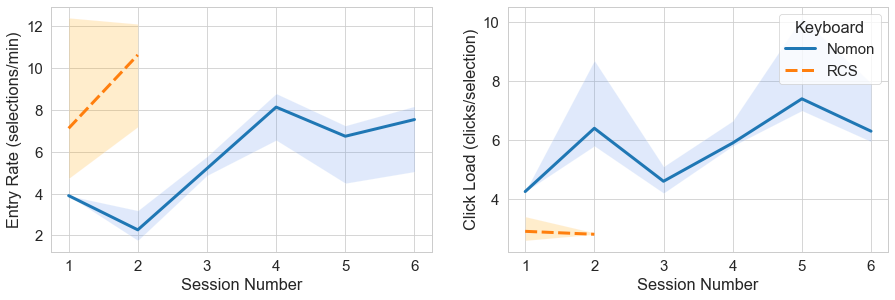

In [20]:

sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")

plot_df = entry_df[entry_df["type"] == "picture"]

metrics = ['Entry Rate (selections/min)', "Click Load (clicks/selection)"]
a4_dims = (15, 5)
_, axes = plt.subplots(1, 2, figsize=a4_dims)
for ax_ind, metric in enumerate(metrics):
    ax = axes[ax_ind]
    plt.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    sns.lineplot(x="Session Number", y=metric, hue="Keyboard", style="Keyboard", estimator=np.median,
                  data=plot_df, ax=ax, ci=None, linewidth=3)
    
    quantiles = calculate_quantiles(plot_df, metric)
        
    if ax_ind == 0:
        ax.get_legend().remove()
    else:
        leg = ax.get_legend()
        for line in leg.get_lines():
            
            line.set_linewidth(3)

    nomon_session_ranges = np.unique(plot_df[plot_df["Keyboard"] == "Nomon"]["Session Number"].to_numpy())
    ax.fill_between(nomon_session_ranges, quantiles["lower"]["nomon"], quantiles["upper"]["nomon"],
                    where=quantiles["upper"]["nomon"] >= quantiles["lower"]["nomon"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)
    
    rowcol_session_ranges = np.unique(plot_df[plot_df["Keyboard"] == "RCS"]["Session Number"].to_numpy())
    ax.fill_between(rowcol_session_ranges, quantiles["lower"]["rowcol"], quantiles["upper"]["rowcol"],
                    where=quantiles["upper"]["rowcol"] >= quantiles["lower"]["rowcol"], facecolor='orange', alpha = 0.2, interpolate=True)
    # ax.axvline(10, color="k")


plt.savefig("data_processing/MI_study/figures/"+str(user)+"/picture_longform.svg")

plt.show()


c:\users\nicholas bonaker\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<Figure size 432x288 with 0 Axes>

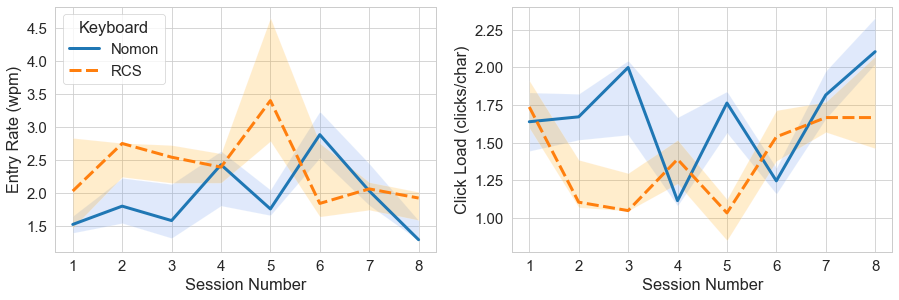

In [26]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")

plot_df = entry_df[entry_df["type"] == "text"]

nomon_indices = plot_df[plot_df["Keyboard"] == "Nomon"].index.to_numpy()
plot_df.loc[nomon_indices, "Session Number"] -= np.min(plot_df[plot_df["Keyboard"] == "Nomon"]["Session Number"])-1

rowcol_indices = plot_df[plot_df["Keyboard"] == "RCS"].index.to_numpy()
plot_df.loc[rowcol_indices, "Session Number"] -= np.min(plot_df[plot_df["Keyboard"] == "RCS"]["Session Number"])-1


metrics = ['Entry Rate (wpm)', "Click Load (clicks/char)"]
a4_dims = (15, 5)
_, axes = plt.subplots(1, 2, figsize=a4_dims)
for ax_ind, metric in enumerate(metrics):
    ax = axes[ax_ind]
    plt.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    sns.lineplot(x="Session Number", y=metric, hue="Keyboard", style="Keyboard", estimator=np.median,
                  data=plot_df, ax=ax, ci=None, linewidth=3)
    
    quantiles = calculate_quantiles(plot_df, metric)
        
    if ax_ind == 1:
        ax.get_legend().remove()
    else:
        ax.legend(title="Keyboard",loc = "upper left")
        leg = ax.get_legend()
        for line in leg.get_lines():
            line.set_linewidth(3)

    nomon_session_ranges = np.unique(plot_df[plot_df["Keyboard"] == "Nomon"]["Session Number"].to_numpy())
    ax.fill_between(nomon_session_ranges, quantiles["lower"]["nomon"], quantiles["upper"]["nomon"],
                    where=quantiles["upper"]["nomon"] >= quantiles["lower"]["nomon"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)
    
    rowcol_session_ranges = np.unique(plot_df[plot_df["Keyboard"] == "RCS"]["Session Number"].to_numpy())
    ax.fill_between(rowcol_session_ranges, quantiles["lower"]["rowcol"], quantiles["upper"]["rowcol"],
                    where=quantiles["upper"]["rowcol"] >= quantiles["lower"]["rowcol"], facecolor='orange', alpha = 0.2, interpolate=True)
    # ax.axvline(10, color="k")


plt.savefig("data_processing/MI_study/figures/"+str(user)+"/text_longform.svg")

plt.show()

[]

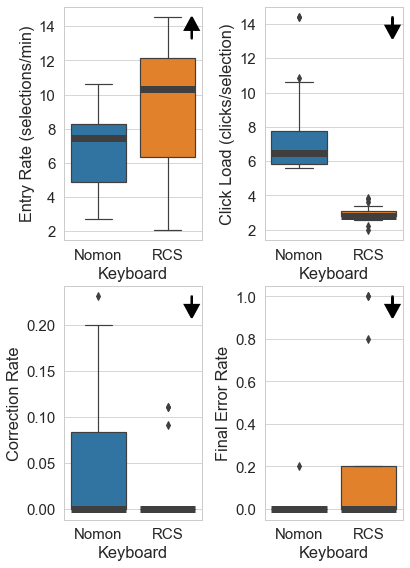

In [21]:

sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
# plt.tight_layout()
sns.set_palette("tab10")

plot_df = entry_df[(entry_df["type"] == "picture")]

nomon_eval_sessions = np.unique(plot_df[plot_df["Keyboard"] == "Nomon"]["Session Number"].to_numpy())[-3:]
rowcol_eval_sessions = np.unique(plot_df[plot_df["Keyboard"] == "RCS"]["Session Number"].to_numpy())[-3:]

plot_df = plot_df[((plot_df["Keyboard"] == "Nomon") & (plot_df["Session Number"].isin(nomon_eval_sessions))) | 
                  ((plot_df["Keyboard"] == "RCS") & (plot_df["Session Number"].isin(rowcol_eval_sessions)))]


entry_stats = ["Entry Rate (selections/min)", "Click Load (clicks/selection)", "Correction Rate", "Final Error Rate"]
fig, axes = plt.subplots(2, 2,figsize=(6,8))
fig.tight_layout(w_pad=1.6)
plt.subplots_adjust(left=0.15)
axes = list(axes)
# fig.suptitle('Entry Statistics for Sessions 7-9')

indicies = [(0,0), (0,1), (1, 0), (1,1)][::-1]
for entry_stat in entry_stats:
    ind = indicies.pop()
    cur_ax = axes[ind[0]][ind[1]]
    
    y_max = np.max(plot_df[entry_stat])
    y_min = np.min(plot_df[entry_stat])
    
    sns.boxplot(x="Keyboard", y=entry_stat, data=plot_df, ax=cur_ax)
    if entry_stat == "Entry Rate (selections/min)":
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.35, y_max - arrow_h, 0, arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    # elif entry_stat == "Final Error Rate":
    #     y_max = np.max(0.1)
    #     y_min = np.min(0)
    #     arrow_h = (y_max-y_min)*0.1
    #     cur_ax.arrow(1.35, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    #     cur_ax.set_ylim(y_min, 0.105)
    elif y_min == y_max:
        y_max = 0.048
        y_min = 0
        arrow_h = (y_max-y_min)*0.1
        
        cur_ax.set_ylim(-0.002, 0.05)

        cur_ax.arrow(1.35, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')

    else:
        y_max = np.max(plot_df[entry_stat])
        y_min = np.min(plot_df[entry_stat])
        
        arrow_h = (y_max-y_min)*0.1

        cur_ax.arrow(1.35, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')

    lines = cur_ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)

plt.savefig("data_processing/MI_study/figures/"+str(user)+"/picture_boxplot.svg")

plt.plot()


[]

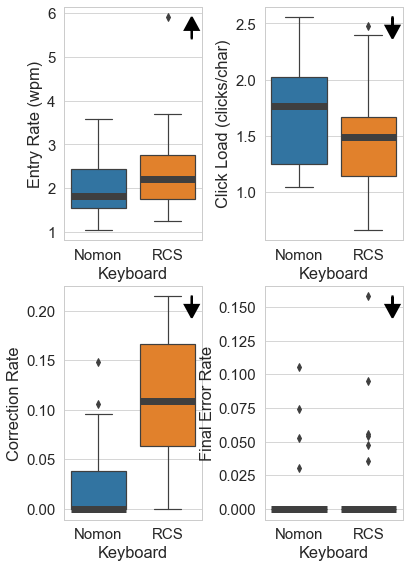

In [28]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
# plt.tight_layout()
sns.set_palette("tab10")

plot_df = entry_df[(entry_df["type"] == "text")]

# nomon_eval_sessions = np.unique(plot_df[plot_df["Keyboard"] == "Nomon"]["Session Number"].to_numpy())[-3:]
# rowcol_eval_sessions = np.unique(plot_df[plot_df["Keyboard"] == "RCS"]["Session Number"].to_numpy())[-3:]
# 
# plot_df = plot_df[((plot_df["Keyboard"] == "Nomon") & (plot_df["Session Number"].isin(nomon_eval_sessions))) | 
#                   ((plot_df["Keyboard"] == "RCS") & (plot_df["Session Number"].isin(rowcol_eval_sessions)))]


entry_stats = ["Entry Rate (wpm)", "Click Load (clicks/char)", "Correction Rate", "Final Error Rate"]
fig, axes = plt.subplots(2, 2,figsize=(6,8))
fig.tight_layout(w_pad=1.6)
plt.subplots_adjust(left=0.15)
axes = list(axes)
# fig.suptitle('Entry Statistics for Sessions 7-9')

indicies = [(0,0), (0,1), (1, 0), (1,1)][::-1]
for entry_stat in entry_stats:
    ind = indicies.pop()
    cur_ax = axes[ind[0]][ind[1]]
    
    y_max = np.max(plot_df[entry_stat])
    y_min = np.min(plot_df[entry_stat])
    
    sns.boxplot(x="Keyboard", y=entry_stat, data=plot_df, ax=cur_ax)
    if entry_stat == "Entry Rate (wpm)":
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.35, y_max - arrow_h, 0, arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    # elif entry_stat == "Final Error Rate":
    #     y_max = np.max(0.1)
    #     y_min = np.min(0)
    #     arrow_h = (y_max-y_min)*0.1
    #     cur_ax.arrow(1.35, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    #     cur_ax.set_ylim(y_min, 0.105)
    elif y_min == y_max:
        y_max = 0.048
        y_min = 0
        arrow_h = (y_max-y_min)*0.1
        
        cur_ax.set_ylim(-0.002, 0.05)

        cur_ax.arrow(1.35, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')

    else:
        y_max = np.max(plot_df[entry_stat])
        y_min = np.min(plot_df[entry_stat])
        
        arrow_h = (y_max-y_min)*0.1

        cur_ax.arrow(1.35, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')

    lines = cur_ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)

plt.savefig("data_processing/MI_study/figures/"+str(user)+"/text_boxplot.svg")

plt.plot()
    

<Figure size 432x288 with 0 Axes>

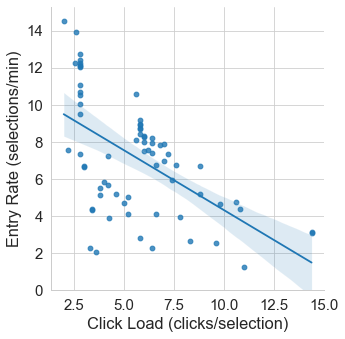

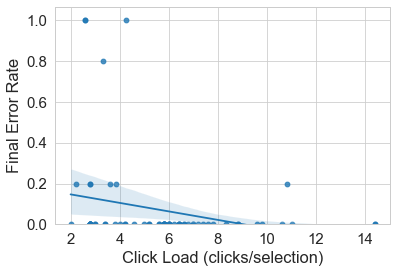

In [6]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")

sns.lmplot(data=entry_df, x="Click Load (clicks/selection)", y="Entry Rate (selections/min)")
plt.gca().set_ylim(bottom=0)
plt.show()

sns.regplot(data=entry_df, x="Click Load (clicks/selection)", y="Final Error Rate")
plt.gca().set_ylim(bottom=0)
plt.show()


<Figure size 432x288 with 0 Axes>

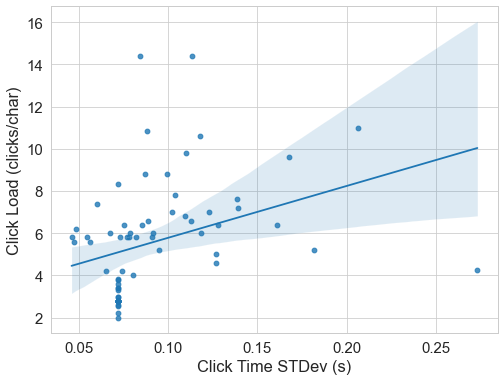

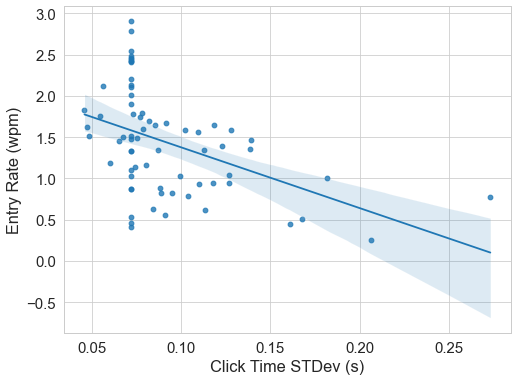

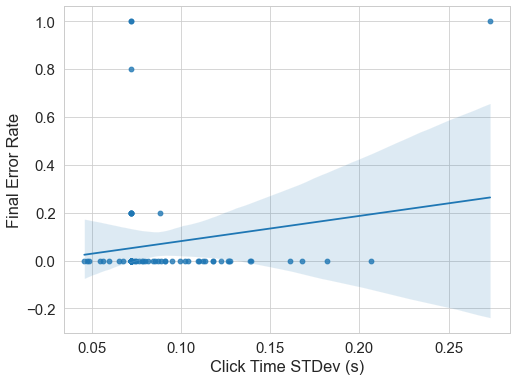

In [7]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")


fig, axes = plt.subplots(1, figsize=(8, 6))
sns.regplot(data=entry_df, x="Click Time STDev (s)", y="Click Load (clicks/char)")
plt.savefig("data_processing/MI_study/figures/"+str(user)+"/click_var_vs_click_load.png", dpi=600)
plt.show()

fig, axes = plt.subplots(1, figsize=(8, 6))
sns.regplot(data=entry_df, x="Click Time STDev (s)", y="Entry Rate (wpm)")
plt.savefig("data_processing/MI_study/figures/"+str(user)+"/click_var_vs_entry_rate.png", dpi=600)

plt.show()

fig, axes = plt.subplots(1, figsize=(8, 6))
sns.regplot(data=entry_df, x="Click Time STDev (s)", y="Final Error Rate")
plt.savefig("data_processing/MI_study/figures/"+str(user)+"/click_var_vs_error.png", dpi=600)

plt.show()

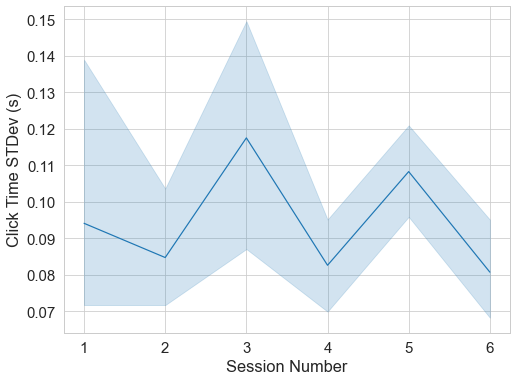

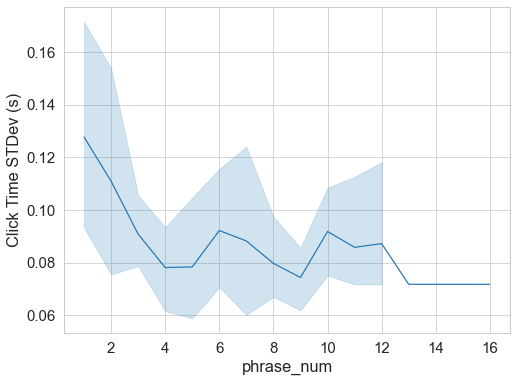

In [22]:
fig, axes = plt.subplots(1, figsize=(8, 6))
sns.lineplot(data=entry_df, y="Click Time STDev (s)", x="Session Number")
plt.savefig("data_processing/MI_study/figures/"+str(user)+"/click_var_vs_session.png", dpi=600)

plt.show()

fig, axes = plt.subplots(1, figsize=(8, 6))
sns.lineplot(data=entry_df, y="Click Time STDev (s)", x="phrase_num")
plt.savefig("data_processing/MI_study/figures/"+str(user)+"/click_var_vs_phrase.png", dpi=600)

plt.show()

In [23]:
entry_df_round = entry_df.applymap(lambda x: round(x, min(int(2 - np.round(np.floor(np.log10(abs(x))))), 3)) if isinstance(x, float) and  np.isfinite(np.round(np.floor(np.log10(abs(x))))) else x)

# Nomon
# picture practice
print_df = entry_df_round[(entry_df_round["Keyboard"] == "Nomon") & (entry_df_round["type"] == "picture")]
nomon_practice_sessions = np.unique(print_df[print_df["Keyboard"] == "Nomon"]["Session Number"].to_numpy())[:-3]
rcs_print_df = print_df[print_df["Session Number"].isin(nomon_practice_sessions)]

data_html_file = 'v1.1.2/html/data_analysis/data_tables/'+str(user)+'/nomon_picture_practice.html'
rcs_print_df[['Session Number', 'Phrase Number', 'Phrase Target', 'Final Typed', 'Time Rotate', 'Entry Rate (selections/min)',
       'Click Load (clicks/selection)', 'Correction Rate',  'Final Error Rate']].to_html(open(data_html_file, 'w'))

with open(data_html_file, 'r') as fin:
    data = fin.read().splitlines(True)
with open(data_html_file, 'w') as fout:
    fout.writelines("    <thead>\n<tr style=\"text-align: right; position: sticky; background-color: white; top: 0;\">")
    fout.writelines(data[3:])
    
# picture eval
print_df = entry_df_round[(entry_df_round["Keyboard"] == "Nomon") & (entry_df_round["type"] == "picture")]
nomon_eval_sessions = np.unique(print_df[print_df["Keyboard"] == "Nomon"]["Session Number"].to_numpy())[-3:]
rcs_print_df = print_df[print_df["Session Number"].isin(nomon_eval_sessions)]

data_html_file = 'v1.1.2/html/data_analysis/data_tables/'+str(user)+'/nomon_picture_eval.html'
rcs_print_df[['Session Number', 'Phrase Number', 'Phrase Target', 'Final Typed', 'Time Rotate', 'Entry Rate (selections/min)',
       'Click Load (clicks/selection)', 'Correction Rate',  'Final Error Rate']].to_html(open(data_html_file, 'w'))

with open(data_html_file, 'r') as fin:
    data = fin.read().splitlines(True)
with open(data_html_file, 'w') as fout:
    fout.writelines("    <thead>\n<tr style=\"text-align: right; position: sticky; background-color: white; top: 0;\">")
    fout.writelines(data[3:])

#text 
print_df = entry_df_round[(entry_df_round["Keyboard"] == "Nomon") & (entry_df_round["type"] == "text")]
data_html_file = 'v1.1.2/html/data_analysis/data_tables/'+str(user)+'/nomon_text.html'
print_df[['Session Number', 'Phrase Number', 'Phrase Target', 'Final Typed', 'is_oov', 'Time Rotate', 'Entry Rate (wpm)',
       'Click Load (clicks/char)', 'Correction Rate',  'Final Error Rate']].to_html(open(data_html_file, 'w'))

with open(data_html_file, 'r') as fin:
    data = fin.read().splitlines(True)
with open(data_html_file, 'w') as fout:
    fout.writelines("    <thead>\n<tr style=\"text-align: right; position: sticky; background-color: white; top: 0;\">")
    fout.writelines(data[3:])

# RCS
# picture practice
print_df = entry_df_round[(entry_df_round["Keyboard"] == "RCS") & (entry_df_round["type"] == "picture")]
rowcol_practice_sessions = np.unique(print_df[print_df["Keyboard"] == "RCS"]["Session Number"].to_numpy())[:-3]
rcs_print_df = print_df[print_df["Session Number"].isin(rowcol_practice_sessions)]

data_html_file = 'v1.1.2/html/data_analysis/data_tables/'+str(user)+'/rcs_picture_practice.html'
rcs_print_df[['Session Number', 'Phrase Number', 'Phrase Target', 'Final Typed', 'Scan Delay', 'Extra Delay', 'Entry Rate (selections/min)',
       'Click Load (clicks/selection)', 'Correction Rate',  'Final Error Rate']].to_html(open(data_html_file, 'w'))

with open(data_html_file, 'r') as fin:
    data = fin.read().splitlines(True)
with open(data_html_file, 'w') as fout:
    fout.writelines("    <thead>\n<tr style=\"text-align: right; position: sticky; background-color: white; top: 0;\">")
    fout.writelines(data[3:])

# picture eval
print_df = entry_df_round[(entry_df_round["Keyboard"] == "RCS") & (entry_df_round["type"] == "picture")]
rowcol_eval_sessions = np.unique(print_df[print_df["Keyboard"] == "RCS"]["Session Number"].to_numpy())[-3:]
rcs_print_df = print_df[print_df["Session Number"].isin(rowcol_eval_sessions)]

data_html_file = 'v1.1.2/html/data_analysis/data_tables/'+str(user)+'/rcs_picture_eval.html'
rcs_print_df[['Session Number', 'Phrase Number', 'Phrase Target', 'Final Typed', 'Scan Delay', 'Extra Delay', 'Entry Rate (selections/min)',
       'Click Load (clicks/selection)', 'Correction Rate',  'Final Error Rate']].to_html(open(data_html_file, 'w'))

with open(data_html_file, 'r') as fin:
    data = fin.read().splitlines(True)
with open(data_html_file, 'w') as fout:
    fout.writelines("    <thead>\n<tr style=\"text-align: right; position: sticky; background-color: white; top: 0;\">")
    fout.writelines(data[3:])
    
# text
print_df = entry_df_round[(entry_df_round["Keyboard"] == "RCS") & (entry_df_round["type"] == "text")]
data_html_file = 'v1.1.2/html/data_analysis/data_tables/'+str(user)+'/rcs_text.html'
print_df[['Session Number', 'Phrase Number', 'Phrase Target', 'Final Typed', 'is_oov', 'Scan Delay', 'Extra Delay', 'Entry Rate (wpm)',
       'Click Load (clicks/char)', 'Correction Rate',  'Final Error Rate']].to_html(open(data_html_file, 'w'))

with open(data_html_file, 'r') as fin:
    data = fin.read().splitlines(True)
with open(data_html_file, 'w') as fout:
    fout.writelines("    <thead>\n<tr style=\"text-align: right; position: sticky; background-color: white; top: 0;\">")
    fout.writelines(data[3:])


c:\users\nicholas bonaker\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


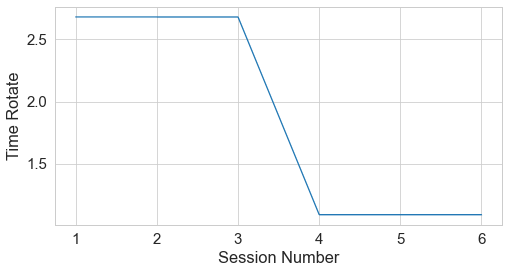

In [24]:
plot_df = entry_df[(entry_df["Keyboard"] == "Nomon") ]
fig, axes = plt.subplots(1, figsize=(8, 4))

sns.lineplot(data=plot_df, y="Time Rotate", x="Session Number")

plt.savefig("data_processing/MI_study/figures/"+str(user)+"/time_rotate.png", dpi=600)

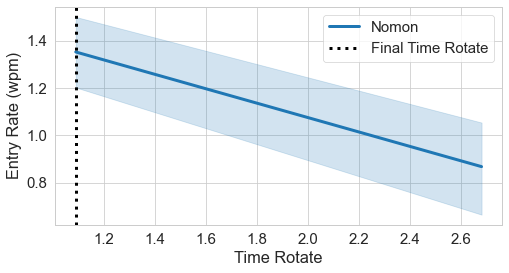

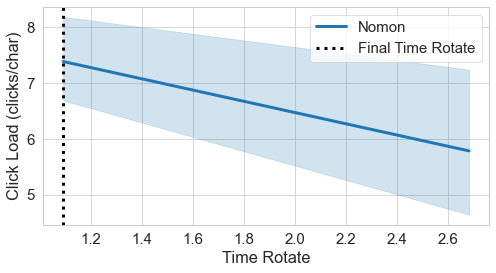

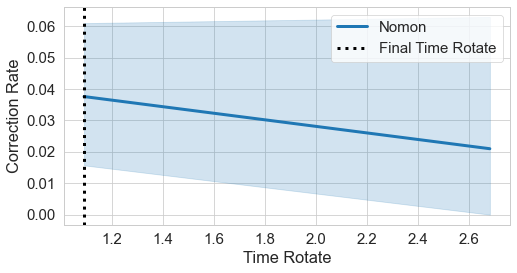

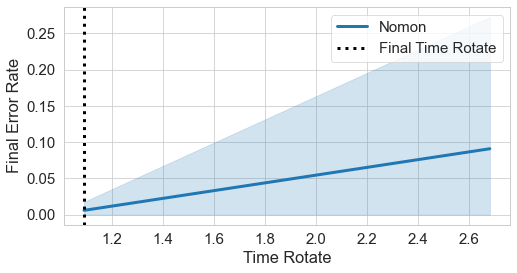

In [25]:
plot_df = entry_df[(entry_df["Keyboard"] == "Nomon") ]
fig, axes = plt.subplots(1, figsize=(8, 4))

sns.lineplot(data=plot_df, y="Entry Rate (wpm)", x="Time Rotate", linewidth=3, label="Nomon")
axes.axvline(plot_df["Time Rotate"].to_numpy()[-1], linewidth=3, linestyle=":", color="k", label="Final Time Rotate")
plt.legend()
plt.savefig("data_processing/MI_study/figures/"+str(user)+"/entry_rate_vs_speed.png", dpi=600)

fig, axes = plt.subplots(1, figsize=(8, 4))

sns.lineplot(data=plot_df, y="Click Load (clicks/char)", x="Time Rotate", linewidth=3, label="Nomon")
axes.axvline(plot_df["Time Rotate"].to_numpy()[-1], linewidth=3, linestyle=":", color="k", label="Final Time Rotate")
plt.legend()
plt.savefig("data_processing/MI_study/figures/"+str(user)+"/click_load_vs_speed.png", dpi=600)

fig, axes = plt.subplots(1, figsize=(8, 4))

sns.lineplot(data=plot_df, y="Correction Rate", x="Time Rotate", linewidth=3, label="Nomon")
axes.axvline(plot_df["Time Rotate"].to_numpy()[-1], linewidth=3, linestyle=":", color="k", label="Final Time Rotate")
plt.legend()
plt.savefig("data_processing/MI_study/figures/"+str(user)+"/correction_vs_speed.png", dpi=600)

fig, axes = plt.subplots(1, figsize=(8, 4))

sns.lineplot(data=plot_df, y="Final Error Rate", x="Time Rotate", linewidth=3, label="Nomon")
axes.axvline(plot_df["Time Rotate"].to_numpy()[-1], linewidth=3, linestyle=":", color="k", label="Final Time Rotate")
plt.legend()
plt.savefig("data_processing/MI_study/figures/"+str(user)+"/error_vs_speed.png", dpi=600)


c:\users\nicholas bonaker\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='Count', ylabel='Click Time STDev (s)'>

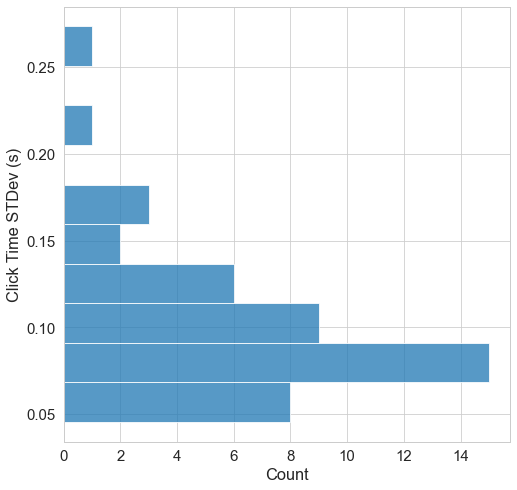

In [26]:
plot_df = entry_df[(entry_df["Keyboard"] == "Nomon") ]
plot_df["Click Time Ratio"] = plot_df["Click Time STDev (s)"]/plot_df["Time Rotate"]
fig, axes = plt.subplots(1, figsize=(8, 8))


# sns.regplot(data=plot_df, y="Click Load (clicks/selection)", x="Click Time Ratio")
sns.histplot(data=plot_df, y="Click Time STDev (s)")

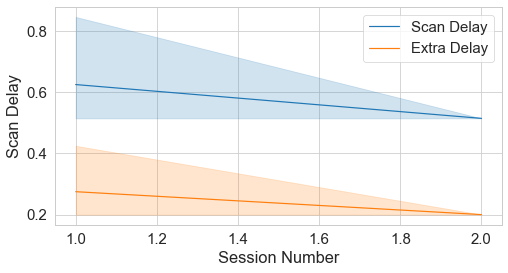

In [27]:
plot_df = entry_df[(entry_df["Keyboard"] == "RCS") ]
fig, axes = plt.subplots(1, figsize=(8, 4))

sns.lineplot(data=plot_df, y="Scan Delay", x="Session Number", label="Scan Delay")
sns.lineplot(data=plot_df, y="Extra Delay", x="Session Number", label="Extra Delay")
plt.legend()

plt.savefig("data_processing/MI_study/figures/"+str(user)+"/rcs_speed.png", dpi=600)

AttributeError: 'NoneType' object has no attribute 'get_lines'

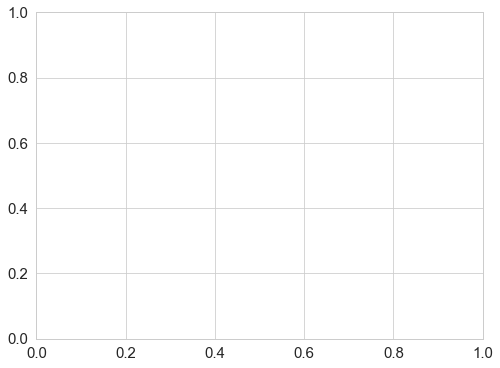

In [28]:
fig, ax = plt.subplots(1, figsize=(8, 6))

plot_df = entry_df[entry_df["type"] == "text"]

nomon_indices = plot_df[plot_df["Keyboard"] == "Nomon"].index.to_numpy()
plot_df.loc[nomon_indices, "Session Number"] -= np.min(plot_df[plot_df["Keyboard"] == "Nomon"]["Session Number"])-1

rowcol_indices = plot_df[plot_df["Keyboard"] == "RCS"].index.to_numpy()
plot_df.loc[rowcol_indices, "Session Number"] -= np.min(plot_df[plot_df["Keyboard"] == "RCS"]["Session Number"])-1


sns.lineplot(data=plot_df, y="Characters/Selection", x="Session Number", hue="Keyboard", style="Keyboard", estimator=np.median, ci=None, linewidth=3)

quantiles = calculate_quantiles(plot_df, "Characters/Selection")
    
leg = ax.get_legend()
for line in leg.get_lines():
    line.set_linewidth(3)
    
ax.set_xticks(np.arange(1, 22))

nomon_session_ranges = np.unique(plot_df[plot_df["Keyboard"] == "Nomon"]["Session Number"].to_numpy())
ax.fill_between(nomon_session_ranges, quantiles["lower"]["nomon"], quantiles["upper"]["nomon"],
                where=quantiles["upper"]["nomon"] >= quantiles["lower"]["nomon"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)

rowcol_session_ranges = np.unique(plot_df[plot_df["Keyboard"] == "RCS"]["Session Number"].to_numpy())
ax.fill_between(rowcol_session_ranges, quantiles["lower"]["rowcol"], quantiles["upper"]["rowcol"],
                where=quantiles["upper"]["rowcol"] >= quantiles["lower"]["rowcol"], facecolor='orange', alpha = 0.2, interpolate=True)

plt.savefig("data_processing/MI_study/figures/"+str(user)+"/word_prediction_long.png", dpi=600)


In [33]:
total_time = entry_df["Total Time"].sum()
print(int(total_time/60), ":", int((total_time/60-np.floor(total_time/60))*60))
total_time *= 1.25
print(int(total_time/60), ":", int((total_time/60-np.floor(total_time/60))*60))

5 : 26
6 : 48


In [16]:
entry_df[entry_df["Total Time"] > 4][["Session Number", "Keyboard", "phrase_num", "Total Time", "Phrase Target"]]


,Session Number,Keyboard,phrase_num,Total Time,Phrase Target
